## Topic Modeling and LDA

Topic Modeling, a method for discovery of representative groups of words from a set of documents, which implicitly present topics. 

In addition, the technique we use is LDA, which is one of the most common topic modeling approaches. The basic idea of LDA is to regard every document as a mixture of topics and to assign every word in a document to one of the document's topics.

However, LDA trains the topic models in an unsupervised way. This has both good and bad aspects. The good part is, we don't have to label the topics of each documents. But in contrast, we can't expect the LDA output to be understandable to human being.   

So, in order to guarantee the quality of a LDA model, we introduce an evaluation approach called coherence value. 

Let us shortly explain how coherence value works. Coherence value approach makes an assumption that if words always appear together, then they are likely to belong to the same topic. And, a topic model with higher coherence value implies a better interpretability to human. 

In the following, with the help of **Gensim** we find documents' topics using LDA and further evaluate the LDA models by computing coherence value.

<font color="blue"/>

### dsp:
  * &#x1f642; Nice to find an introductory text here at the top of the Notebook.
  * To consider a topic a "representative group of words" is not exact. In the context of LDA the topic is represented by a probability distribution over all words. Picking the most probable words as a desription of the topic is only an approximation.

### Gensim functions we use
1. LdaModel(corpus, id2word, num_topics): train a LDA model
    - params:
        - corpus: gensim corpus
        - id2word: mapping from word IDs to words. [Dictionay](https://radimrehurek.com/gensim/corpora/dictionary.html) type, defined by gensim library
        - num_topics: user-defined number of topics
    - return:
        - gensim LDA model
2. CoherenceModel(model, corpus, coherence): build a model for topic coherence
    - params:
        - model: gensim LDA model
        - corpus: gensim corpus
        - coherence: way of coherence measure, "u_mass" or "c_v"
    - return:
        - gensim coherence model
3. get_coherence(): a method of gensim coherence model class
    - return: coherence value of the gensim coherence model

<font color="blue"/>

### dsp:
  * It might be useful to desribe the structure of the gensim LDA model.
  * "u_mass" and "c_v" are never explained in this Notebook
  * "Dictionay" ~> "Dictionary"

In [ ]:
from gensim import corpora, models, similarities
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim
import os
import shutil
import pickle
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import time
from matplotlib import colors
pyLDAvis.enable_notebook()

<font color="blue"/>

### dsp:
  * This import list might benefit from some sorting and some empty lines to give it some structure.

#### 0. Create data set with all bank quarterly reports
- params:
    - source_folder: path to the corpus folder (e.g. "../spacy_corpus/") 
    - target_folder: path to the target folder (e.g. "../bank_quarterly_report/")
    - non_german_file_path: path to the "non_german_files.txt"

In [12]:
def pick_bank_quarterly_report(source_folder, target_folder, non_german_file_path):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    
    non_german_files = []
    with open(non_german_file_path, 'r') as fr:
        for line in fr:
            non_german_files.append(line.strip())    

    texts = []
    filenames = []

    for root, dirs, files in os.walk(source_folder):
        for f in files:
            if f[:-11] not in non_german_files and ("Bank" in f or "bank" in f) and ("Quarterly" in f or "quarterly" in f):
                try:
                    src_file = root + '/' + f
                    shutil.copy(src_file, target_folder)
                except:
                    print('Error while creating data set for LDA: ', f)

In [ ]:
target_folder = '../bank_quarterly_report/'
source_folder = '../spacy_corpus/'
non_german_file_path = './non_german_files.txt'

pick_bank_quarterly_report(source_folder, target_folder, non_german_file_path)

<font color="blue"/>

### dsp:
  * (I haven't had the energy to verify the folder structure here. I had some problems with relative paths because Python seemed to resolve the symbolic link.)



<font color="blue"/>

### dsp:
  * &#x1f642; Defining a function in one cell and then calling it in the next cell is a pattern that I have now seen quite a few times. It has the benefits, that you have a function definition that you can call a few times with different parameters, and you are able to see some results in the second cell. That is a pattern worth repeating.

#### 1. Initialize LDA -- compute prerequisite data for LDA 
- params:
    - folder_path: cleand preprocessed data folder
    - non_german_file_path: a list of all English files
- return variables:
    - texts: list of input text
    - dct: [Dictionay](https://radimrehurek.com/gensim/corpora/dictionary.html) type, defined by gensim library
    - corpus: doc2bow, tokenized and nomalized list

In [14]:
def LDA_initialize(folder_path):
    texts = []
    filenames = []

    for root, dirs, files in os.walk(folder_path):
        for f in files:
            try:
                with open(root+'/'+f, 'rb') as fr:
                    filenames.append(f)
                    document_tokens = pickle.load(fr)
                    texts.append(document_tokens)
            except:
                print('Error while processing: ', f)
    
    dct = Dictionary(texts)
    corpus = [dct.doc2bow(doc) for doc in texts]
    
    return texts, dct, corpus

#### Note:
**In this notebook, the data set we use is the collection of all bank quartly reports.** 

Please check the [Folder Structure](01-Convert_JSON_to_TXT.ipynb) if there is running error.

**non_german_files.txt** should be located in the same folder! If not, please use the absolute path to locate that file.

**bank_quartely_report** should be located under Text_Mining_Lab folder! If not, try to use the absolute path to the folder

In [15]:
%%time
warnings.filterwarnings("ignore")
#please modify the path
# non_german_file_path = '/home/bit/chao/LabShare/data/non_german_files.txt'
# bank_quarterly_report_path = '/home/bit/chao/LabShare/data/chui_ma/bank_quarterly_report/'
bank_quarterly_report_path = '../bank_quarterly_report/'
texts, dct, corpus = LDA_initialize(bank_quarterly_report_path)

CPU times: user 1.82 s, sys: 79.1 ms, total: 1.9 s
Wall time: 1.91 s


#### 2. LDA Topic Modeling and Model Evaluation
In this stage, we try multiple topic models with different numbers of topics and compute the coherence values of them.
> step 2.1 get_model_list(): 
>> get a list of LDA models with different numbers of topics from multiple calls of Gensim function **LdaModel()**

> step 2.2 compute_coherence_values(): 
>> get a list of CV and UMass coherence values of each topic model by calling Gensim function **CoherenceModel()** per model.

#### step 2.1: get_model_list(dictionary, corpus, limit, start=2, step=3)
- params:
    - dictionary: gensim dictionary
    - corpus: gensim corpus
    - start, limit, step: test topic numbers from **start** to **limit** with a step size **step**
- return variables:
    - model_list: a list of LDA models

In [16]:
def get_model_list(dictionary, corpus, limit, start=2, step=3):
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)

    return model_list

#### step 2.2: compute_coherence_values(model_list, dictionary, corpus, texts)

- params:
    - model_list : List of LDA topic models
    - dictionary : gensim dictionary
    - corpus : gensim corpus
    - texts : list of input texts

- variables:
    - CV_coherence_values : a list of CV coherence values of LDA models
    - UM_coherence_values : a list of UMass coherence values of LDA models

In [17]:
def compute_coherence_values(model_list, dictionary, corpus, texts):
    CV_coherence_values = []
    UM_coherence_values = []
    for model in model_list:
        CVcoherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        CV_coherence_values.append(CVcoherencemodel.get_coherence())
        
        UMcoherencemodel = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        UM_coherence_values.append(UMcoherencemodel.get_coherence())        

    return CV_coherence_values, UM_coherence_values

### main function of experiment

In [18]:
%%time
start = 5
limit = 20
step = 1

model_list = get_model_list(dictionary=dct, corpus=corpus, start=start, limit=limit, step=step)
CV_coherence_values, UMass_coherence_values = compute_coherence_values(model_list, dictionary=dct, corpus=corpus, texts=texts)

CPU times: user 2min 25s, sys: 18.3 s, total: 2min 43s
Wall time: 7min 23s


### visualize the evalution process
- params:
    - start, limit, step: test topic numbers from **start** to **limit** with a step size **step**
    - CV_coherence_values, UMass_coherence_values: output from **compute_coherence_values** function

In [19]:
def visualize_coherence_scores(start, limit, step, UMass_coherence_values, CV_coherence_values):
    # Show UMass scores
    plt.figure()
    x = range(start, limit, step)
    plt.plot(x, UMass_coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("UMass Coherence score")
    plt.legend(("UMass_coherence_values"), loc='best')
    plt.show()

    # Show CV scores
    plt.figure()
    plt.plot(x, CV_coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("CV Coherence score")
    plt.legend(("CV_coherence_values"), loc='best')
    plt.show()

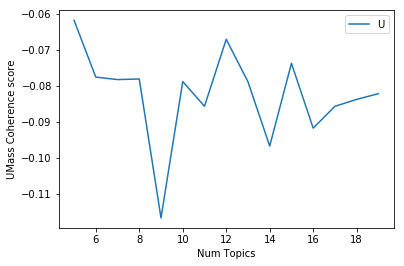

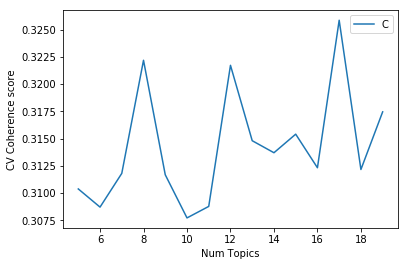

In [20]:
visualize_coherence_scores(start, limit, step, UMass_coherence_values, CV_coherence_values)

### decide the number of topics and visualize the best LDA model
- selection scheme: test those numbers of topics with rather higher coherence scores

In [21]:
best_UMass_model = model_list[np.argmax(UMass_coherence_values) ]
pyLDAvis.gensim.prepare(best_UMass_model, corpus, dct)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.005031  0.000392       1        1  34.955128
2      0.000203 -0.001493       2        1  20.156000
1      0.001462  0.001944       3        1  18.767281
4      0.001541 -0.003429       4        1  14.655057
3      0.001825  0.002585       5        1  11.466537, topic_info=      Category         Freq            Term        Total  loglift  logprob
term                                                                      
443    Default  4645.000000         deutsch  4645.000000  30.0000  30.0000
198    Default  5318.000000            bank  5318.000000  29.0000  29.0000
948    Default  2709.000000            ifrs  2709.000000  28.0000  28.0000
2068   Default  4190.000000      wesentlich  4190.000000  27.0000  27.0000
136    Default  2879.000000        aufgrund  2879.000000  26.0000  26.0000
1479   Default  3636.000000         quartal  3636.000000  25.0000  25.0000
450    Default  3293.000000        dezember  3293.000000  24.0000  24.0000
1132   Default  2066.000000          kunden  2066.000000  23.0000  23.0000
624    Default  2736.000000         erträge  2736.000000  22.0000  22.0000
1189   Default  2914.000000          liegen  2914.000000  21.0000  21.0000
893    Default  3067.000000        halbjahr  3067.000000  20.0000  20.0000
1089   Default  1873.000000        konzerns  1873.000000  19.0000  19.0000
767    Default  1954.000000           gemäß  1954.000000  18.0000  18.0000
1959   Default  1632.000000  vermögenswerte  1632.000000  17.0000  17.0000
1743   Default  2634.000000         steuern  2634.000000  16.0000  16.0000
2017   Default  1869.000000         vorjahr  1869.000000  15.0000  15.0000
211    Default  1755.000000           basis  1755.000000  14.0000  14.0000
192    Default  1174.000000    auswirkungen  1174.000000  13.0000  13.0000
1553   Default  2016.000000         risiken  2016.000000  12.0000  12.0000
636    Default  1293.000000      europäisch  1293.000000  11.0000  11.0000
580    Default  1514.000000         ergeben  1514.000000  10.0000  10.0000
702    Default  1406.000000     forderungen  1406.000000   9.0000   9.0000
1893   Default  1601.000000           value  1601.000000   8.0000   8.0000
581    Default  4544.000000        ergebnis  4544.000000   7.0000   7.0000
13141  Default  1223.000000          helaba  1223.000000   6.0000   6.0000
1544   Default  1756.000000     resultieren  1756.000000   5.0000   5.0000
626    Default  1735.000000        erwarten  1735.000000   4.0000   4.0000
942    Default  4817.000000            höhe  4817.000000   3.0000   3.0000
1079   Default  2724.000000         konzern  2724.000000   2.0000   2.0000
937    Default  3179.000000            hoch  3179.000000   1.0000   1.0000
...        ...          ...             ...          ...      ...      ...
1089    Topic5   247.712296        konzerns  1873.321899   0.1425  -6.0559
1553    Topic5   262.202759         risiken  2016.503906   0.1257  -5.9991
1189    Topic5   355.545959          liegen  2914.638672   0.0619  -5.6945
930     Topic5   168.992233          hinaus  1230.354126   0.1805  -6.4383
249     Topic5   221.750534        belaufen  1707.586304   0.1245  -6.1666
767     Topic5   246.225311           gemäß  1954.422485   0.0941  -6.0619
292     Topic5   147.608612        bestehen  1062.970093   0.1915  -6.5736
580     Topic5   196.222122         ergeben  1514.904785   0.1219  -6.2889
942     Topic5   505.116760            höhe  4817.540527  -0.0895  -5.3434
1482    Topic5   259.577972          rahmen  2131.511230   0.0602  -6.0091
624     Topic5   316.046295         erträge  2736.397217   0.0072  -5.8123
1893    Topic5   205.164658           value  1601.072144   0.1111  -6.2444
2068    Topic5   441.406494      wesentlich  4190.809570  -0.0849  -5.4782
1743    Topic5   298.014313         steuern  2634.423584  -0.0135  -5.8710
626     Topic5   217.402664        erwarten  1735.3356